In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pyvbmc import VBMC
from joblib import Parallel, delayed
import corner



from psiam_tied_dv_map_utils import up_RTs_fit_fn, down_RTs_fit_fn, psiam_tied_data_gen_wrapper
from psiam_tied_utils import  rho_A_t_fn, all_RTs_fit_fn

# params

In [2]:
# stim params
ABL_arr = [20, 40, 60]
# ILD_arr = [-6, -3, 0, 3, 6]
ILD_arr = [-8, -4, -2, -1,  1,  2, 4, 8]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)

V_A = 0.5
theta_A = 1

t_stim = 0.25
t_A_aff = 0.02
t_E_aff = 0.03
t_motor = 0.04
Z_E = 0 

# DV map
L = 1

# sim params
N_sim = int(25e3)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim, t_A_aff, t_E_aff, t_motor, L, dt)\
                                                                                  for _ in range(N_sim))

# loglike fn

In [4]:
def compute_loglike(res, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    if rt < t_stim:
        likelihood = rho_A_t_fn(rt - t_motor - t_A_aff, V_A, theta_A)
    else:
        if choice == 1:
            likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, \
                                       theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]
        elif choice == -1:
            likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,\
                                          theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L = params


    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L)\
                                       for res in sim_results)

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [5]:
V_A_bounds = [0.2, 1.2]
theta_A_bounds = [0.5, 1.5]

rate_lambda_bounds = [0.01, 0.15]
T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
theta_E_bounds = [35, 65]

t_A_aff_bounds = [0.009, 0.07]
t_E_aff_bounds = [0.009, 0.07]
t_motor_bounds = [0.009, 0.07]

Z_E_bounds = [-10, 10]
L_bounds = [0.5, 1.5]
# ---
V_A_plausible_bounds = [0.3, 1]
theta_A_plausible_bounds = [0.7, 1.3]

rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.3*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_A_aff_plausible_bounds = [0.01, 0.05]
t_E_aff_plausible_bounds = [0.01, 0.05]
t_motor_plausible_bounds = [0.01, 0.05]

Z_E_plausible_bounds = [-5, 5]
L_plausible_bounds = [0.8, 1.2]

# True
# V_A = 0.5
# theta_A = 1

# rate_lambda = 0.076
# T_0 = 0.19*(1e-3)
# theta_E = 50.7

# t_A_aff = 0.02
# t_E_aff = 0.03
# t_motor = 0.04

# L = 2


# prior

In [6]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    
    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    t_motor_logpdf = trapezoidal_logpdf(t_motor, t_motor_bounds[0], t_motor_plausible_bounds[0], t_motor_plausible_bounds[1], t_motor_bounds[1])

    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])
    return V_A_logpdf + theta_A_logpdf + rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_A_aff_logpdf + t_E_aff_logpdf + t_motor_logpdf + Z_E_logpdf + L_logpdf


# prior + loglike

In [7]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

# run vbmc

In [8]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_A_aff_bounds[0], t_E_aff_bounds[0], t_motor_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
               t_A_aff_bounds[1], t_E_aff_bounds[1], t_motor_bounds[1], Z_E_bounds[1], L_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], \
                rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0],\
                t_A_aff_plausible_bounds[0], t_E_aff_plausible_bounds[0], t_motor_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1],\
                rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1],\
                t_A_aff_plausible_bounds[1], t_E_aff_plausible_bounds[1], t_motor_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
t_motor_0 = np.random.uniform(t_motor_plausible_bounds[0], t_motor_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, rate_lambda_0, T_0_0, theta_E_0, t_A_aff_0, t_E_aff_0, t_motor_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 10).
Reshaping upper bounds to (1, 10).
Reshaping plausible lower bounds to (1, 10).
Reshaping plausible upper bounds to (1, 10).


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 12247.939 +/-0.065.


# corner plot

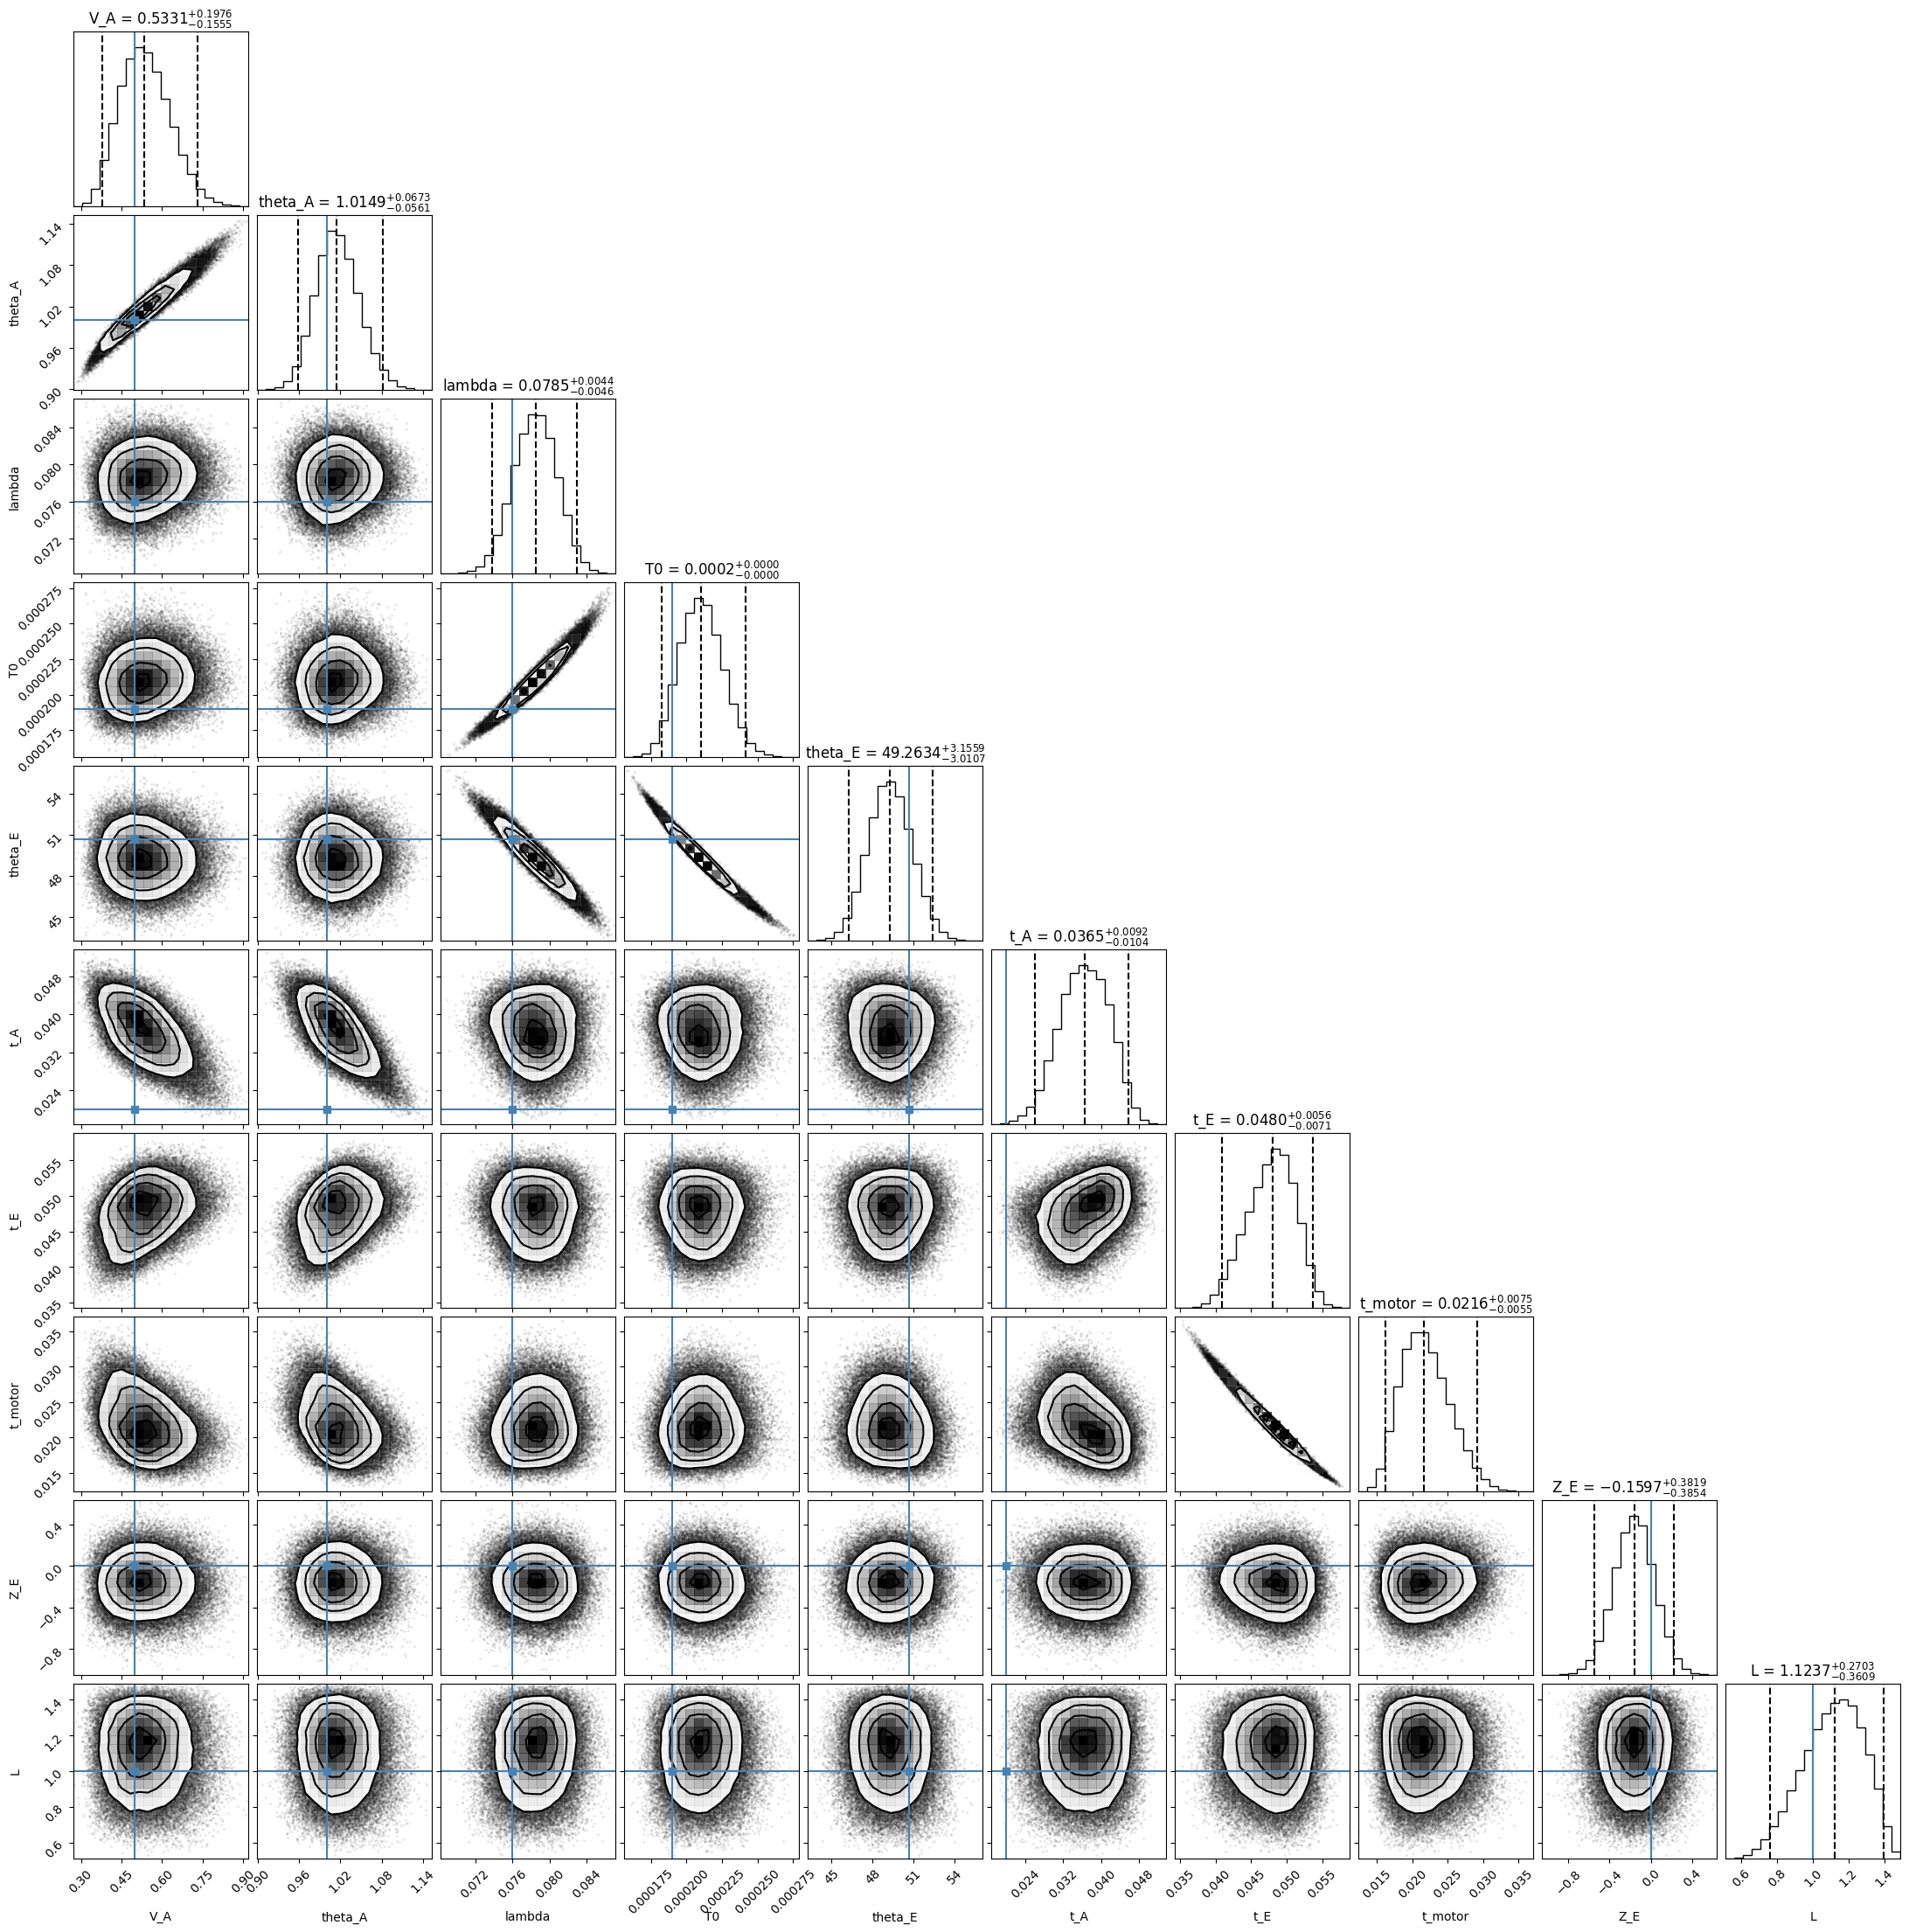

In [9]:
vp_samples = vp.sample(int(1e5))[0]

param_labels = ['V_A', 'theta_A', 'lambda', 'T0', 'theta_E', 't_A', 't_E', 't_motor', 'Z_E', 'L']
true_arr = [V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L]

# percentiles = np.percentile(vp_samples, [0.5, 99.5], axis=0)
percentiles = np.percentile(vp_samples, [0, 100], axis=0)


_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    truths=true_arr,
    title_fmt=".4f"
);

# check likelihood - true vs mean

In [10]:
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

In [11]:
# likelihood of true params
true_loglike = psiam_tied_loglike_fn([V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L])
# likelihood of mean params
mean_vb_loglike = psiam_tied_loglike_fn([mean_vb_params['V_A'], mean_vb_params['theta_A'], mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], mean_vb_params['Z_E'], mean_vb_params['L']])
print(f"True loglike/1e3: {true_loglike/1e3}")
print(f"Mean VB loglike/1e3: {mean_vb_loglike/1e3}")

True loglike/1e3: 12.262673350944317
Mean VB loglike/1e3: 12.275326753974205


# taco curves

/tmp/ipykernel_2977974/3624208912.py:10: RuntimeWarning: invalid value encountered in divide
  real_taco = real_up/(real_up + real_down)
/tmp/ipykernel_2977974/3624208912.py:14: RuntimeWarning: invalid value encountered in divide
  mean_taco = mean_up/(mean_up + mean_down)


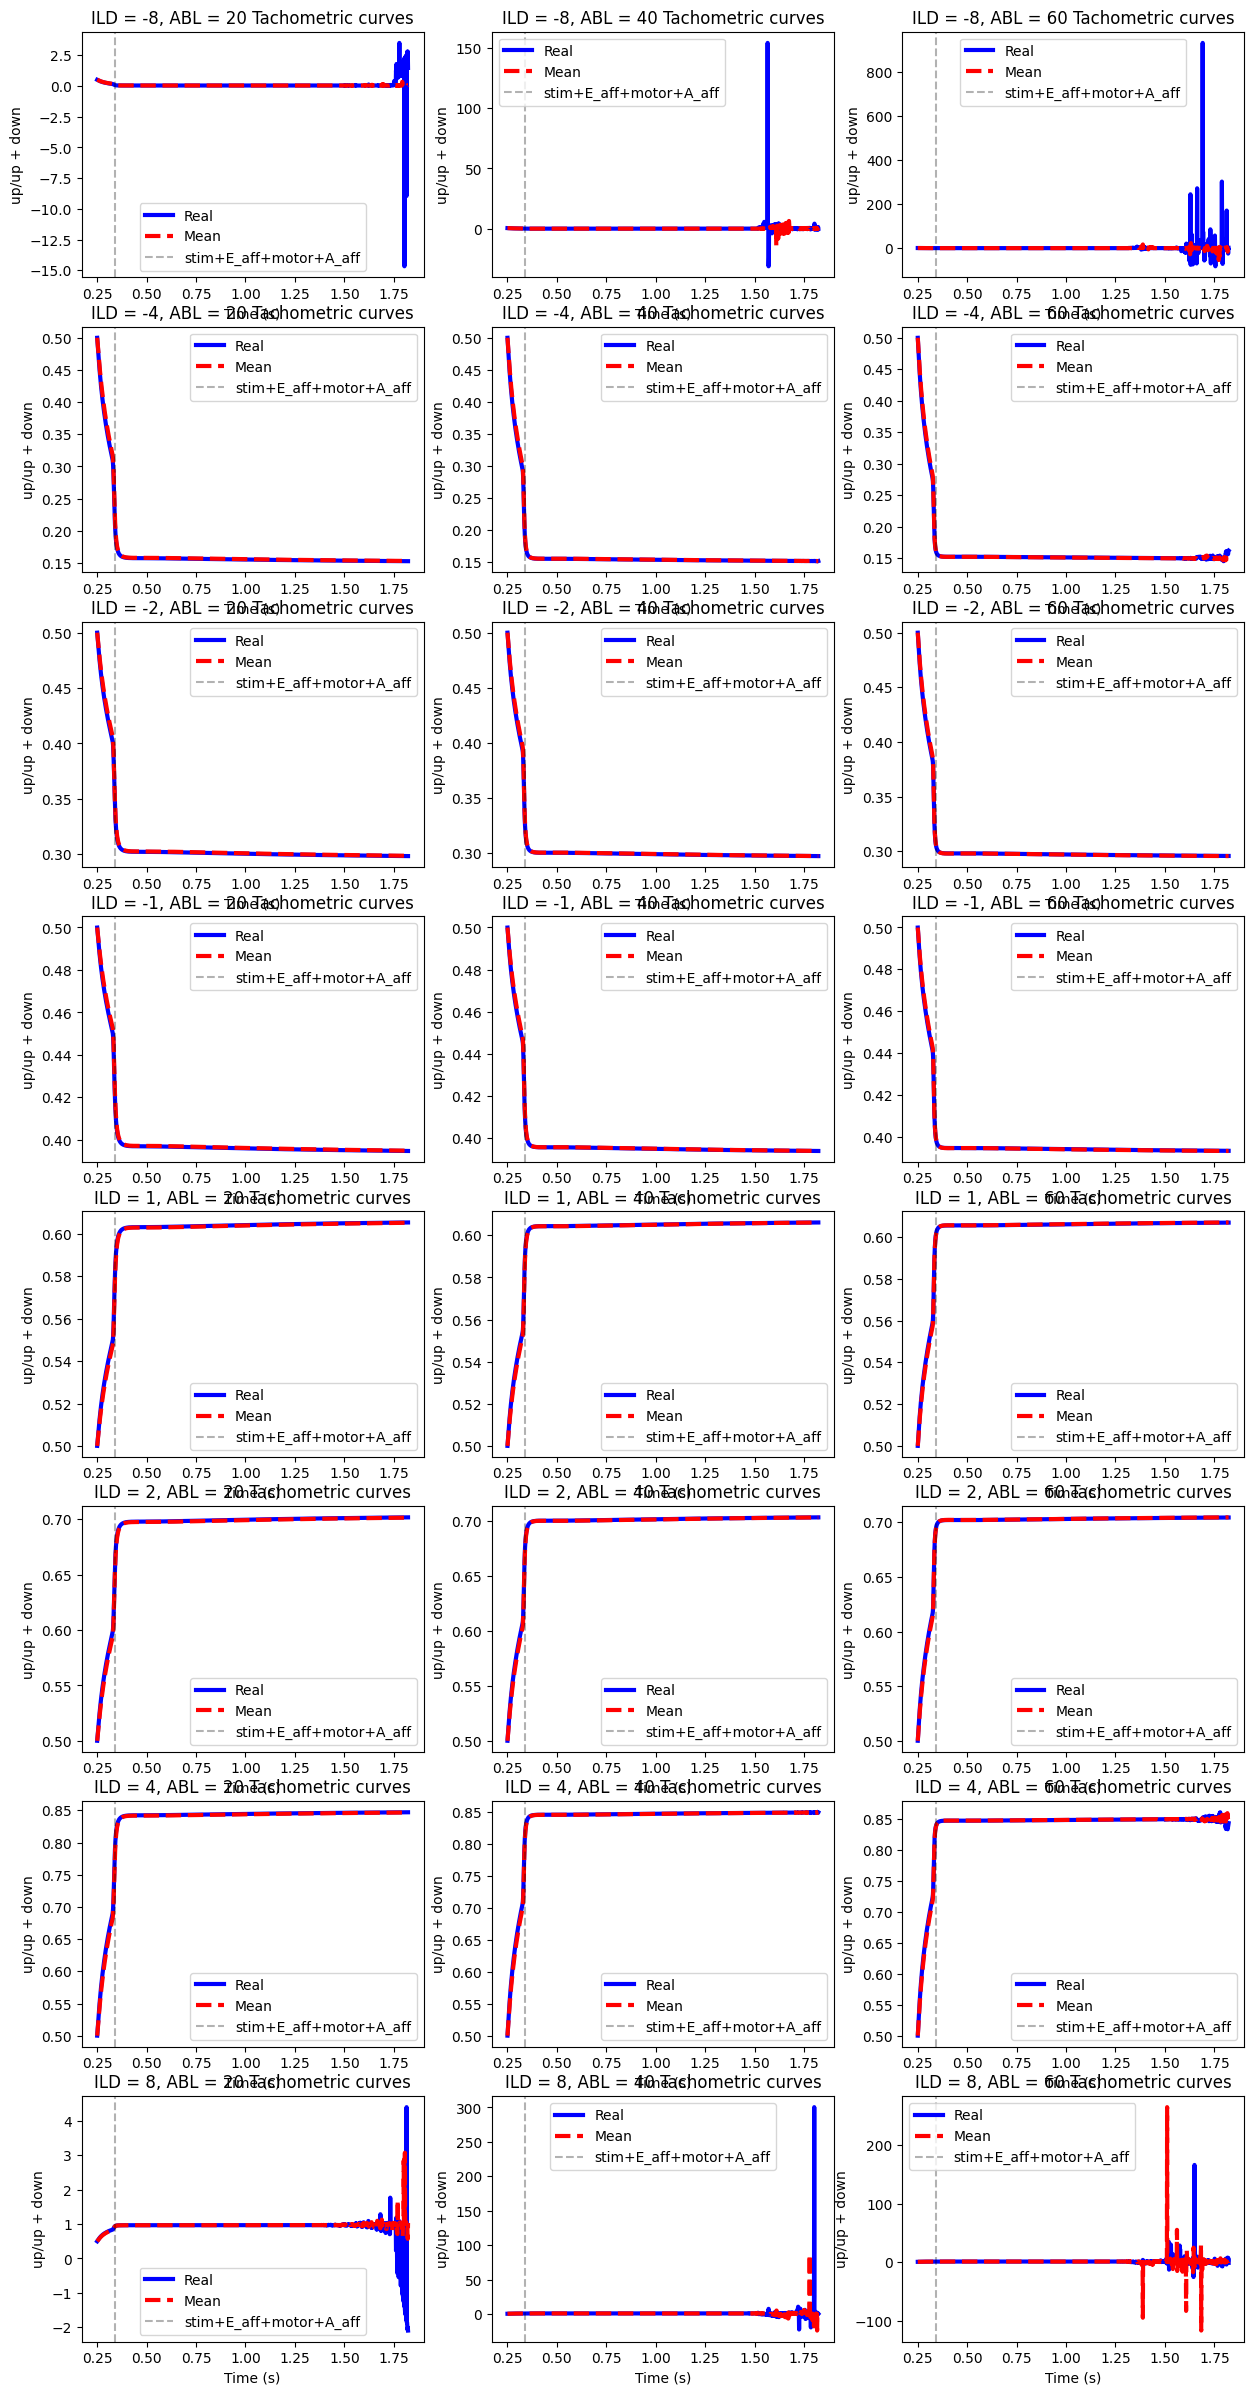

In [12]:
all_rt = [res['rt'] for res in sim_results]
max_all_rt = np.max(all_rt)
t_pts = np.linspace(0.001, max_all_rt, 1500)
plt.figure(figsize=(15, 30))
fig_num = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:
        real_up = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)
        real_down = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L,  K_max)
        real_taco = real_up/(real_up + real_down)

        mean_up = up_RTs_fit_fn(t_pts, mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], Z_E, t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], mean_vb_params['L'], K_max)
        mean_down = down_RTs_fit_fn(t_pts, mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], Z_E, t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], mean_vb_params['L'] ,K_max)
        mean_taco = mean_up/(mean_up + mean_down)

        
        plt.subplot(len(ILD_arr),len(ABL_arr),fig_num)
        plt.plot(t_pts, real_taco, label='Real', linestyle='-', color='b', linewidth=3);
        plt.plot(t_pts, mean_taco, label='Mean', linestyle='--', color='r',  linewidth=3);
        plt.axvline(t_stim + t_E_aff + t_motor + t_A_aff, color='k', linestyle='--', label='stim+E_aff+motor+A_aff', alpha=0.3)

        plt.legend();
        plt.xlabel('Time (s)');plt.ylabel('up/up + down');plt.title(f'ILD = {ILD}, ABL = {ABL} Tachometric curves');

        # plt.xlim([0.1, 2])
        # plt.ylim([np.nanmean(real_taco) - 1e-2, np.nanmean(real_taco) + 1e-2])
        if ILD == 0:
            plt.ylim([0.49, 0.51])

        fig_num += 1


# tacho- all ILD in one ABL

/tmp/ipykernel_2977974/1794367827.py:14: RuntimeWarning: invalid value encountered in divide
  real_taco = real_up/(real_up + real_down)
/tmp/ipykernel_2977974/1794367827.py:18: RuntimeWarning: invalid value encountered in divide
  mean_taco = mean_up/(mean_up + mean_down)


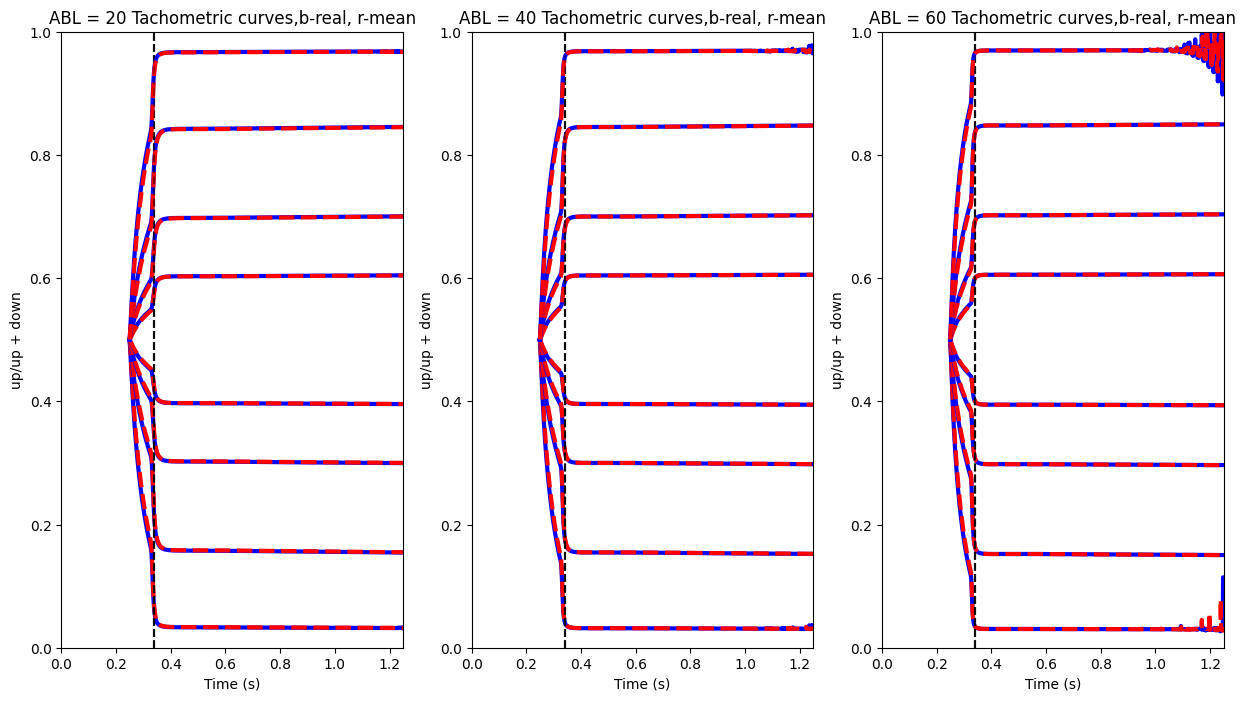

In [15]:
# for each ABL, plot tachometric curves for all ILDs in one figure
all_rt = [res['rt'] for res in sim_results]
max_all_rt = np.max(all_rt)
t_pts = np.linspace(0.001, max_all_rt, 1500)

plt.figure(figsize=(15, 8))
fig_num = 1
for ABL in ABL_arr:
    plt.subplot(1, len(ABL_arr), fig_num)

    for ILD in ILD_arr:
        real_up = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L,  K_max)
        real_down = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)
        real_taco = real_up/(real_up + real_down)

        mean_up = up_RTs_fit_fn(t_pts, mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], Z_E, t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], mean_vb_params['L'],K_max)
        mean_down = down_RTs_fit_fn(t_pts, mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], Z_E, t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], mean_vb_params['L'] ,K_max)
        mean_taco = mean_up/(mean_up + mean_down)

        
        plt.plot(t_pts, real_taco, label='Real', linestyle='-', color='b', linewidth=3);
        plt.plot(t_pts, mean_taco, label='Mean', linestyle='--', color='r',  linewidth=3);
        plt.axvline(t_stim + t_E_aff + t_motor + t_A_aff, color='k', linestyle='--', label='stim+E_aff+motor+A_aff', alpha=0.3)

        # plt.legend();

        plt.xlim([0, 1.25])
        plt.ylim([0, 1])
        # plt.ylim([np.nanmean(real_taco) - 1e-2, np.nanmean(real_taco) + 1e-2])
        
    plt.xlabel('Time (s)');plt.ylabel('up/up + down');plt.title(f'ABL = {ABL} Tachometric curves,b-real, r-mean');


    fig_num += 1


# simulate data with VP params and compare with True theory curves

using mean of samples

In [16]:
vp_samples = vp.sample(int(1e6))[0]
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

gen data

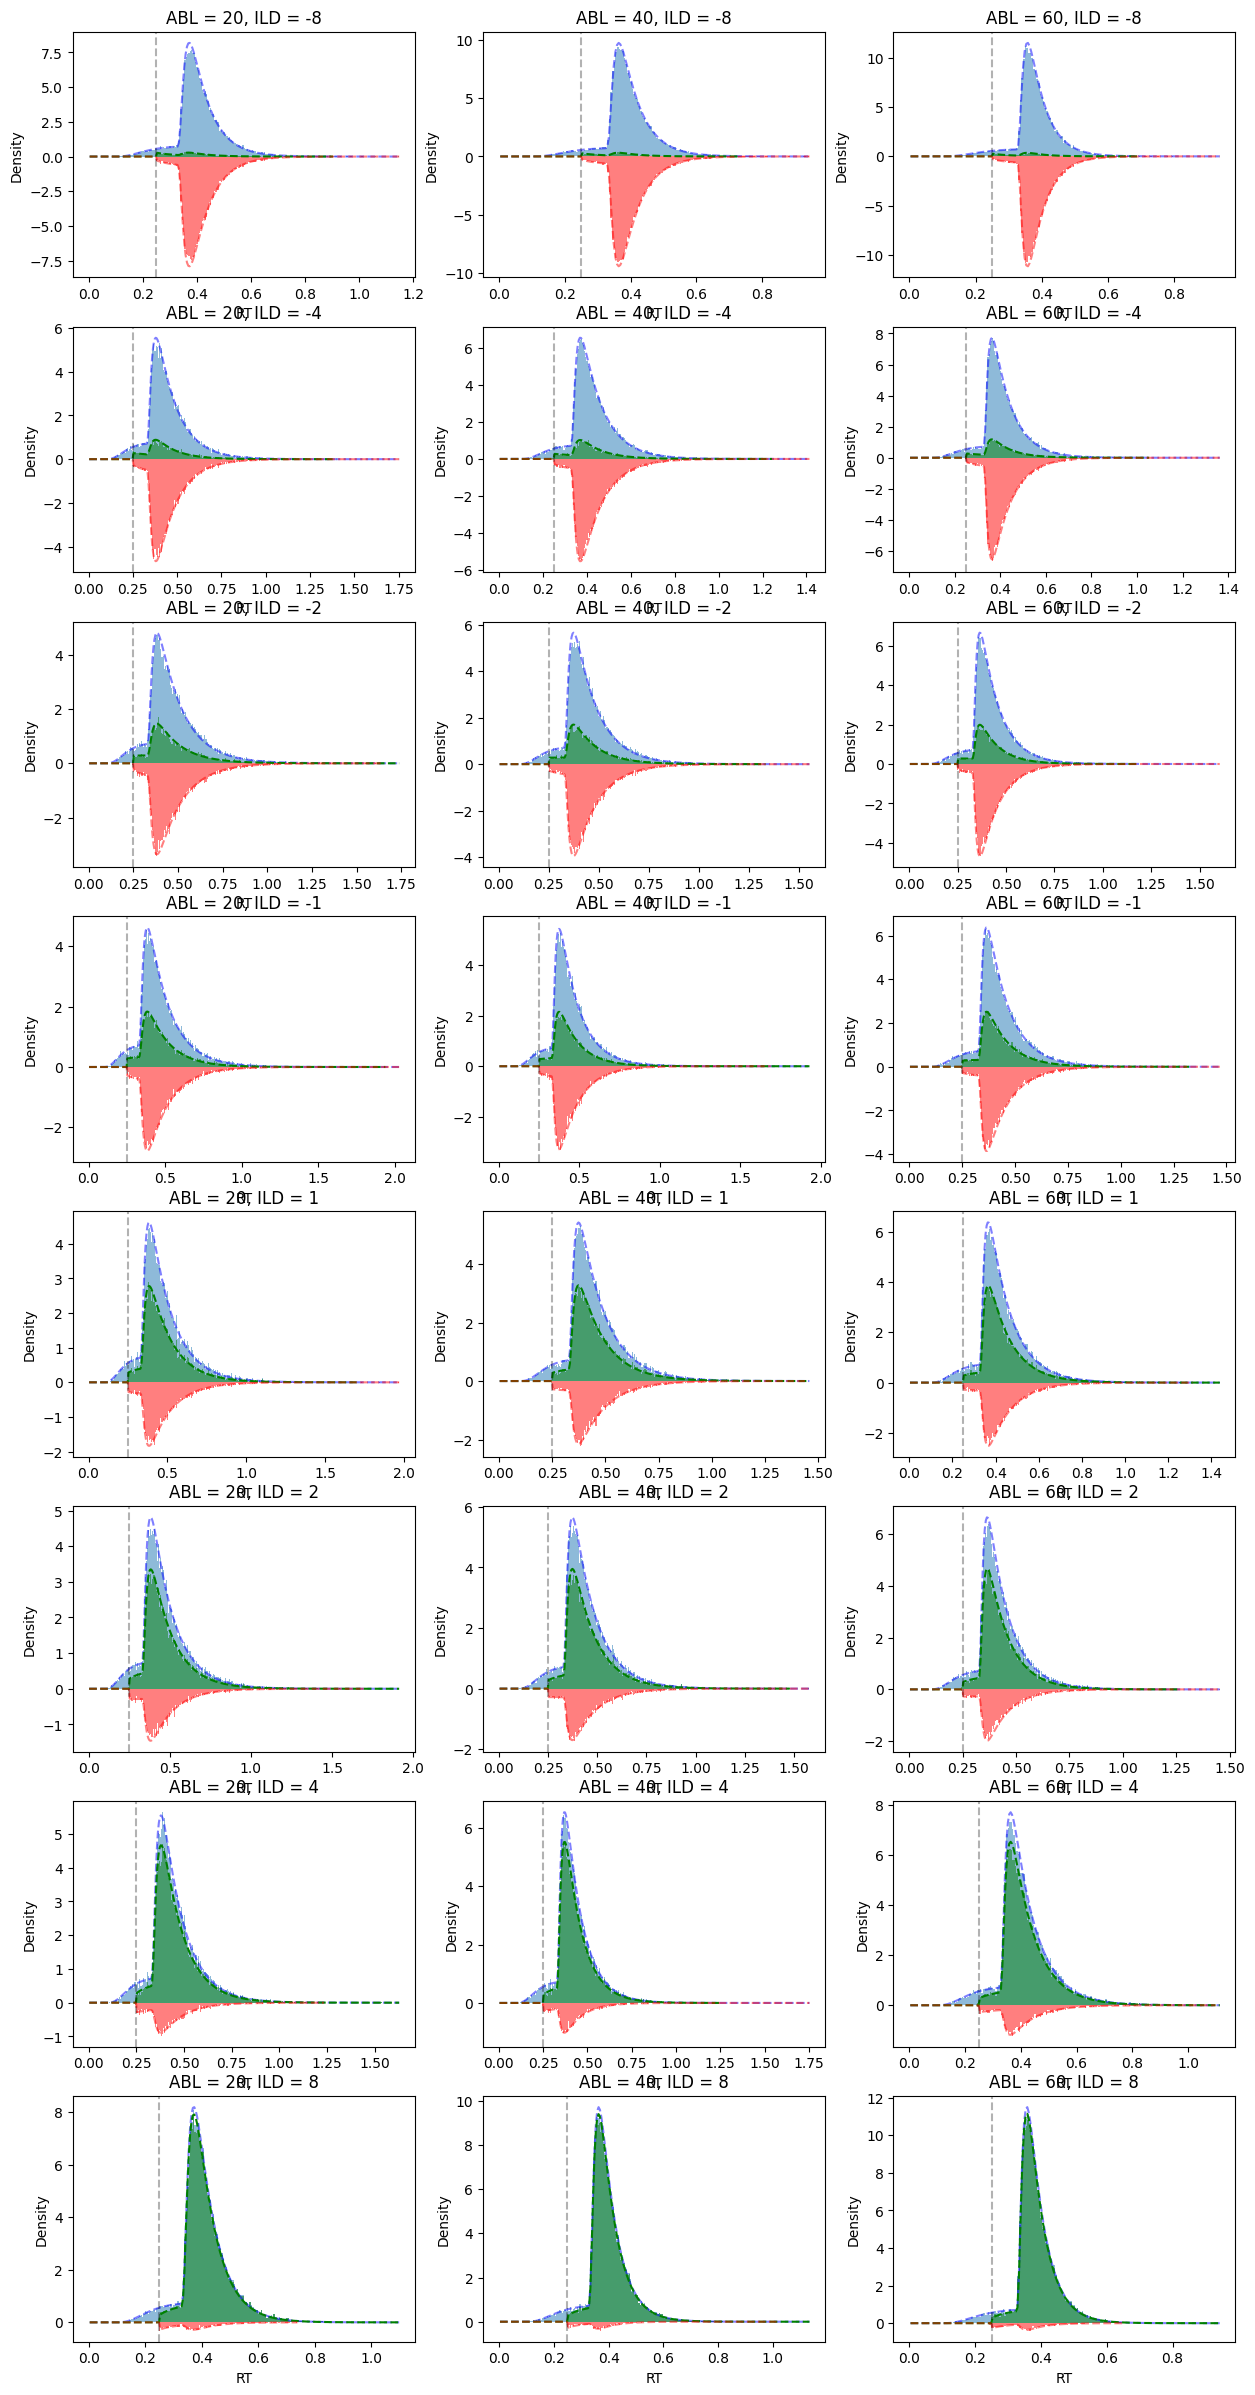

In [18]:
n_rows_fig = len(ILD_arr); n_cols_fig = len(ABL_arr); fig_num = 1;
bin_width = 0.005

plt.figure(figsize=(15,30))
for i in range(len(ILD_arr)):
    for a in range(len(ABL_arr)):
        ABL = ABL_arr[a]
        ILD = ILD_arr[i]

        sim_results_ABL_ILD = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(mean_vb_params['V_A'], mean_vb_params['theta_A'], \
                                                                                      [ABL], [ILD], mean_vb_params['lambda'], \
                                                                                        mean_vb_params['T0'],mean_vb_params['theta_E'], \
                                                                                        mean_vb_params['Z_E'], t_stim, \
                                                                                        mean_vb_params['t_A'], mean_vb_params['t_E'],\
                                                                                        mean_vb_params['t_motor'], mean_vb_params['L'], dt)\
                                                                                          for _ in range(N_sim))

        # all data
        vb_all_rt = np.array([res['rt'] for res in sim_results_ABL_ILD])
        vb_all_choice = np.array([res['choice'] for res in sim_results_ABL_ILD])

        # all 
        all_bins = np.arange(0.001, max(vb_all_rt) + bin_width, bin_width)
        all_hist, _ = np.histogram(vb_all_rt, bins=all_bins, density=True)

        t_pts_all = all_bins[:-1] + bin_width/2
        true_theory_ABL_ILD_all = all_RTs_fit_fn(t_pts_all, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

        # up
        up_rt_idx = np.where(vb_all_choice == 1)[0]
        up_rt = vb_all_rt[up_rt_idx]
        non_abort_up_rt_idx = np.where(up_rt > t_stim)[0]
        up_rt = up_rt[non_abort_up_rt_idx]

        up_bins = np.arange(0.001, max(up_rt) + bin_width, bin_width)
        up_hist, _ = np.histogram(up_rt, bins=up_bins, density=True)
        up_hist *= len(up_rt)/len(all_rt)

        t_pts_up = up_bins[:-1] + bin_width/2
        true_theory_ABL_ILD_up = up_RTs_fit_fn(t_pts_up, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)

        # down
        down_rt_idx = np.where(vb_all_choice == -1)[0]
        down_rt = vb_all_rt[down_rt_idx]

        non_abort_down_rt_idx = np.where(down_rt > t_stim)[0]
        down_rt = down_rt[non_abort_down_rt_idx]

        down_bins = np.arange(0.001, max(down_rt) + bin_width, bin_width)
        down_hist, _ = np.histogram(down_rt, bins=down_bins, density=True)
        down_hist *= len(down_rt)/len(all_rt)

        t_pts_down = down_bins[:-1] + bin_width/2
        true_theory_ABL_ILD_down = down_RTs_fit_fn(t_pts_down,V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max) 

        plt.subplot(n_rows_fig, n_cols_fig, fig_num)
        plt.bar(all_bins[:-1], all_hist, width=bin_width, alpha=0.5, label='sim with mean VP');
        plt.plot(t_pts_all, true_theory_ABL_ILD_all, label='theory true param', linestyle='--', color='b', alpha = 0.5);

        plt.bar(up_bins[:-1], up_hist, width=bin_width, alpha=0.5, label='up sim with mean VP', color='g');
        plt.plot(t_pts_up, true_theory_ABL_ILD_up, label='theory true param', linestyle='--', color='g');

        plt.bar(down_bins[:-1], -down_hist, width=bin_width, alpha=0.5, label='down sim with mean VP', color='r');
        plt.plot(t_pts_down, -true_theory_ABL_ILD_down, label='theory true param', linestyle='--', color='r', alpha = 0.5);

        plt.axvline(x=t_stim, color='k', linestyle='--', label='stim', alpha=0.3)
        plt.xlabel('RT');plt.ylabel('Density');plt.title(f'ABL = {ABL}, ILD = {ILD}')

        fig_num += 1

# psychometric function

In [24]:
from scipy.integrate import quad
from psiam_tied_dv_map_utils import prob_x_t_and_hit_up_or_down_analytic

from psiam_tied_utils import CDF_E_minus_small_t_NORM_fn, rho_E_minus_small_t_NORM_fn, P_small_t_btn_x1_x2, cum_A_t_fn


def up_RTs_fit_fn_single_t(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)
    P_EA_btn_1_2 = prob_x_t_and_hit_up_or_down_analytic(t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, K_max, bound) + P_small_t_btn_x1_x2(1+L/2, 2, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_E_plus = rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)

    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm


In [25]:
prob_up_dict = {}
prob_up_dict_no_abort = {}
theory_prob_up_dict = {}
for a in ABL_arr:
    prob_up_dict[a] = np.zeros((len(ILD_arr)))
    prob_up_dict_no_abort[a] = np.zeros((len(ILD_arr)))
    theory_prob_up_dict[a] = np.zeros((len(ILD_arr)))


for a in range(len(ABL_arr)):
    for i in range(len(ILD_arr)):
        ABL = ABL_arr[a]
        ILD = ILD_arr[i]

        sim_results_ABL_ILD = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(mean_vb_params['V_A'], mean_vb_params['theta_A'], \
                                                                                              [ABL], [ILD], mean_vb_params['lambda'], \
                                                                                                mean_vb_params['T0'],mean_vb_params['theta_E'], \
                                                                                                mean_vb_params['Z_E'], t_stim, \
                                                                                                mean_vb_params['t_A'], mean_vb_params['t_E'],\
                                                                                                mean_vb_params['t_motor'], mean_vb_params['L'] , dt)\
                                                                                                  for _ in range(N_sim))


        vb_all_choice = np.array([res['choice'] for res in sim_results_ABL_ILD])
        prob_up_data =  len(np.where(vb_all_choice == 1)[0])/len(vb_all_choice)

        vb_all_rt = np.array([res['rt'] for res in sim_results_ABL_ILD])
        vb_non_abort_idx = np.where(vb_all_rt > t_stim)[0]
        choice_non_abort = vb_all_choice[vb_non_abort_idx]
        prob_up_data_non_abort = len(np.where(choice_non_abort == 1)[0])/len(vb_all_choice)

        integ_const_up = quad(up_RTs_fit_fn_single_t, 0.001, 50, args=(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max))[0]

        prob_up_dict[ABL][i] = prob_up_data
        prob_up_dict_no_abort[ABL][i] = prob_up_data_non_abort
        theory_prob_up_dict[ABL][i] = integ_const_up

/tmp/ipykernel_2977974/3992205067.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ_const_up = quad(up_RTs_fit_fn_single_t, 0.001, 50, args=(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max))[0]


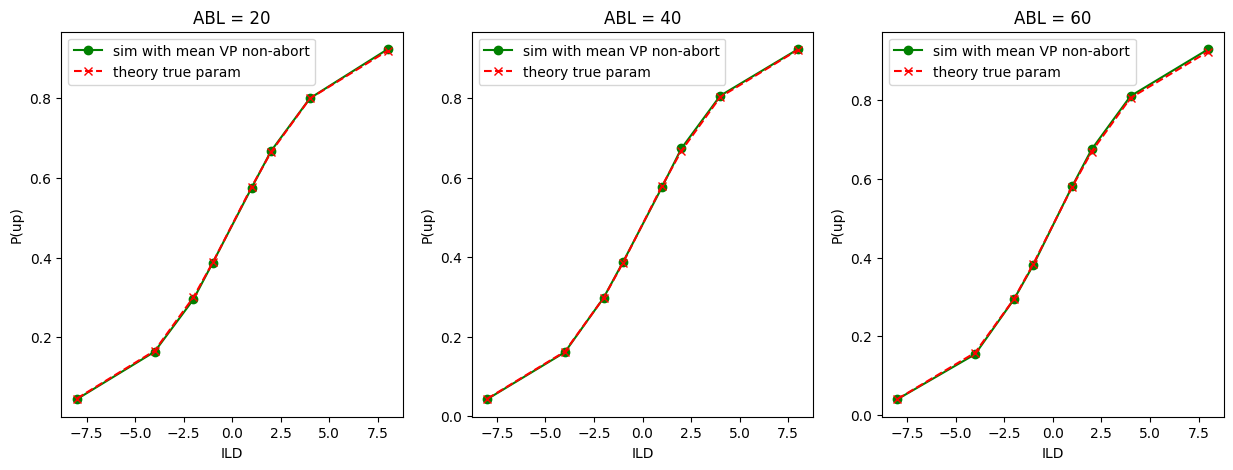

In [26]:
plt.figure(figsize=(15, 5))
for a in range(len(ABL_arr)):
    plt.subplot(1,len(ABL_arr), a+1)
    # plt.plot(ILD_arr, prob_up_dict[ABL_arr[a]], label='sim with mean VP', marker='o', linestyle='-', color='b');
    plt.plot(ILD_arr, prob_up_dict_no_abort[ABL_arr[a]], label='sim with mean VP non-abort', marker='o', linestyle='-', color='g');
    plt.plot(ILD_arr, theory_prob_up_dict[ABL_arr[a]], label='theory true param', marker='x', linestyle='--', color='r');
    plt.xlabel('ILD');plt.ylabel('P(up)');plt.title(f'ABL = {ABL_arr[a]}')
    plt.legend();

# percentiles

In [27]:
quartile_vals = [10, 30, 50, 70, 90]

vb_rt_percentile_dict = {}
true_rt_percentile_dict = {}
for ABL in ABL_arr:
    vb_rt_percentile_dict[ABL] = np.zeros((len(ILD_arr), len(quartile_vals)))
    true_rt_percentile_dict[ABL] = np.zeros((len(ILD_arr), len(quartile_vals)))


for a in range(len(ABL_arr)):
    for i in range(len(ILD_arr)):
        ABL = ABL_arr[a]
        ILD = ILD_arr[i]

        sim_results_ABL_ILD = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(mean_vb_params['V_A'], mean_vb_params['theta_A'], \
                                                                                            [ABL], [ILD], mean_vb_params['lambda'], \
                                                                                            mean_vb_params['T0'],mean_vb_params['theta_E'], \
                                                                                            mean_vb_params['Z_E'], t_stim, \
                                                                                            mean_vb_params['t_A'], mean_vb_params['t_E'],\
                                                                                            mean_vb_params['t_motor'], mean_vb_params['L'], dt)\
                                                                                                for _ in range(N_sim))
        sim_results_real_params = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, \
                                                                                            [ABL], [ILD], rate_lambda, \
                                                                                            T_0, theta_E, \
                                                                                            Z_E, t_stim, \
                                                                                            t_A_aff, t_E_aff,\
                                                                                            t_motor, L, dt)\
                                                                                                for _ in range(N_sim))

        vb_rt = np.array([res['rt'] for res in sim_results_ABL_ILD])
        true_rt = np.array([res['rt'] for res in sim_results_real_params])


        # get quartiles
        vb_quartiles = np.percentile(vb_rt, quartile_vals)
        true_quartiles = np.percentile(true_rt, quartile_vals)

        vb_rt_percentile_dict[ABL][i,:] = vb_quartiles
        true_rt_percentile_dict[ABL][i,:] = true_quartiles



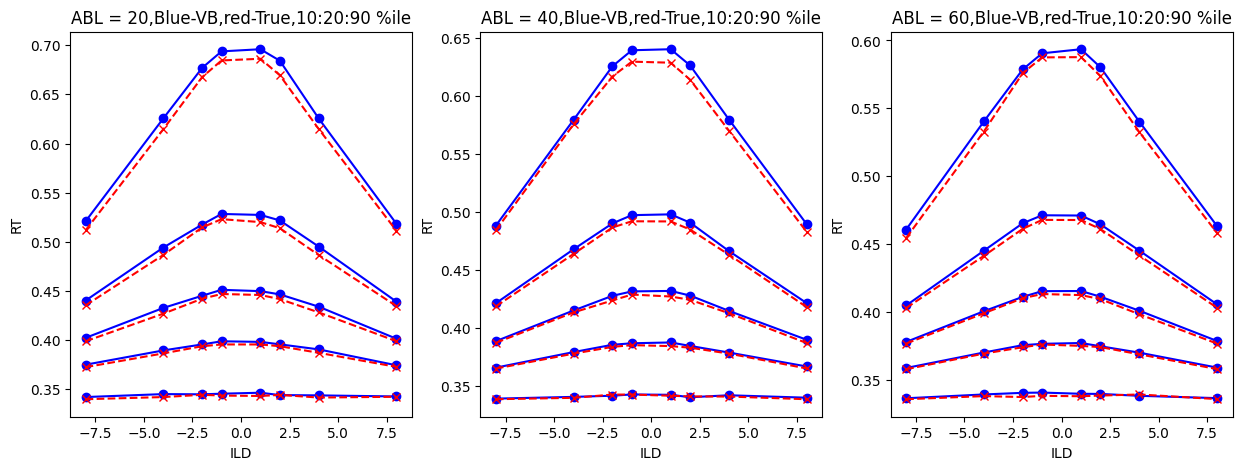

In [28]:
plt.figure(figsize=(15, 5))
for a in range(len(ABL_arr)):
    plt.subplot(1,len(ABL_arr), a+1)
    for q in range(len(quartile_vals)):
        plt.plot(ILD_arr, vb_rt_percentile_dict[ABL_arr[a]][:, q], label=f'VB {quartile_vals[q]}', marker='o', linestyle='-', color='b');
        plt.plot(ILD_arr, true_rt_percentile_dict[ABL_arr[a]][:, q], label=f'True {quartile_vals[q]}', marker='x', linestyle='--', color='r');
    plt.xlabel('ILD');plt.ylabel('RT');plt.title(f'ABL = {ABL_arr[a]},Blue-VB,red-True,10:20:90 %ile')